### Spectral Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color = cols)

def plot_2d(m, title = '') :
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

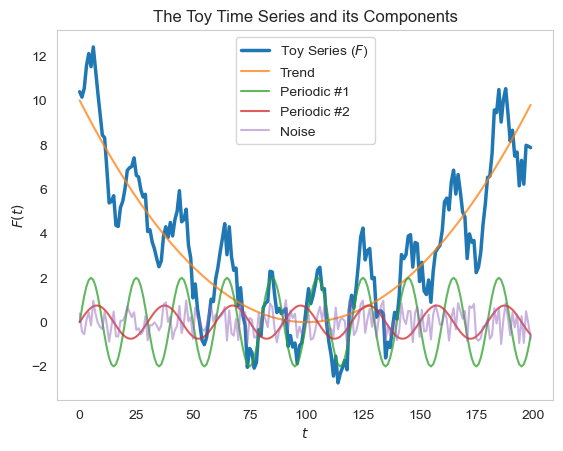

In [4]:
from numpy import pi
N = 200 # The number of time 'moments' in our toy series
t = np.arange(0,N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

np.random.seed(123) # So we generate the same noisy time series every time.
noise = 2 * (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

# Plot everything
plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.grid(False)
plt.legend(["Toy Series ($F$)", "Trend", "Periodic #1", "Periodic #2", "Noise"])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("The Toy Time Series and its Components");

#### SSA methods

In [5]:
L = 70 # The window length.
K = N - L + 1 # The number of columns in the trajectory matrix.
# Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
X = np.column_stack([F[i:i+L] for i in range(0,K)])
# Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 

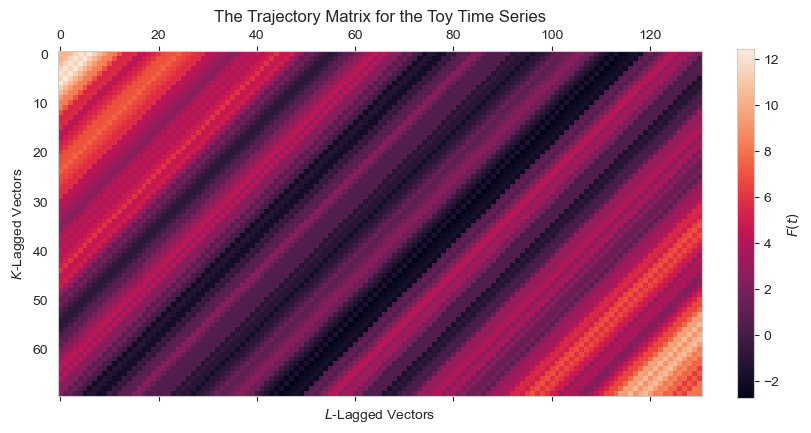

In [7]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.grid(False)
plt.title("The Trajectory Matrix for the Toy Time Series");

In [8]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

# For those interested in how to code up an SVD calculation, Numerical Recipes in Fortran 77
# has you covered: http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf
# Thankfully, we'll leave the actual SVD calculation to NumPy.
U, Sigma, V = np.linalg.svd(X)
V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
# but I'll treat the Python representation of V consistently with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

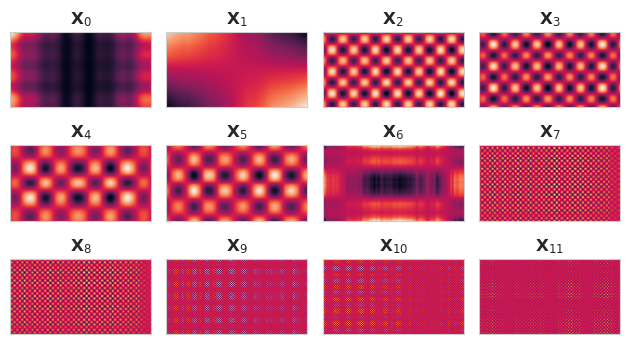

In [9]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

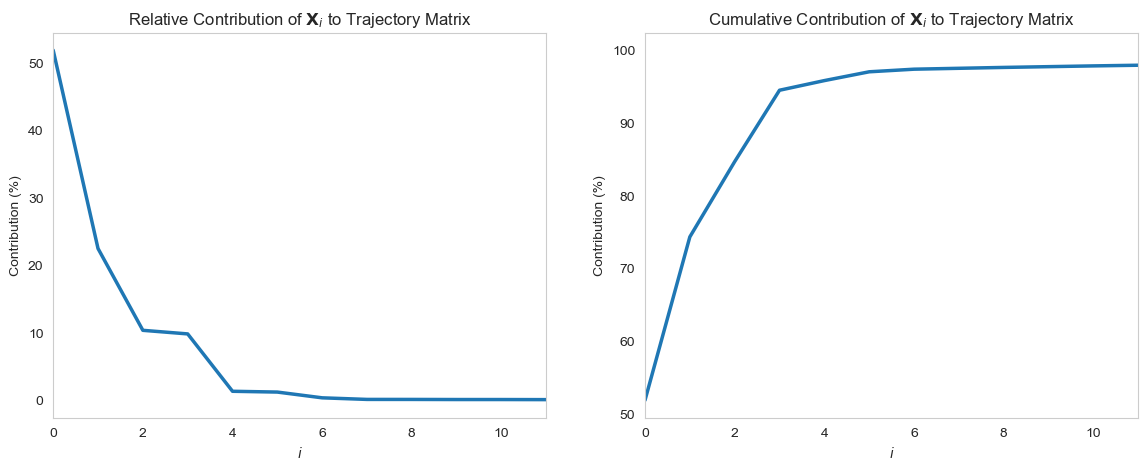

In [11]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].grid(False)
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].grid(False)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

In [12]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

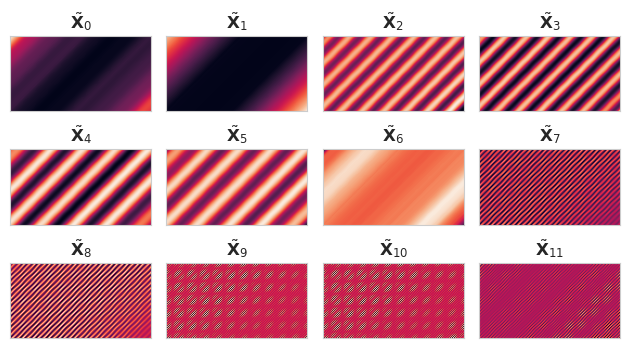

In [13]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

In [14]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

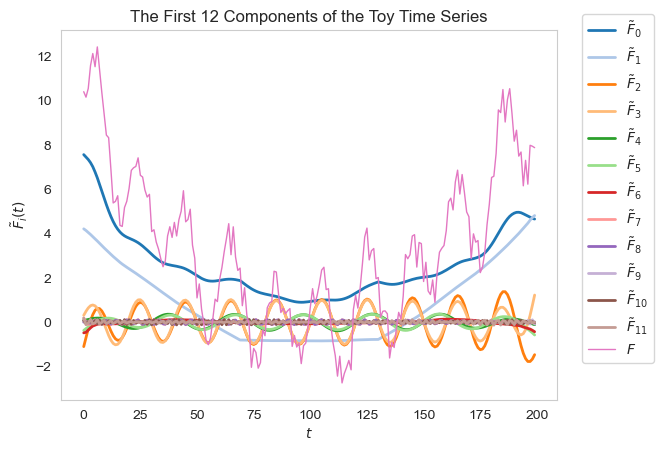

In [16]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
plt.grid(False)
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

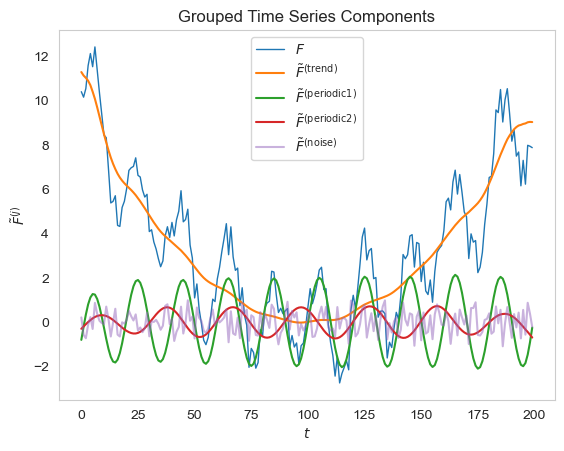

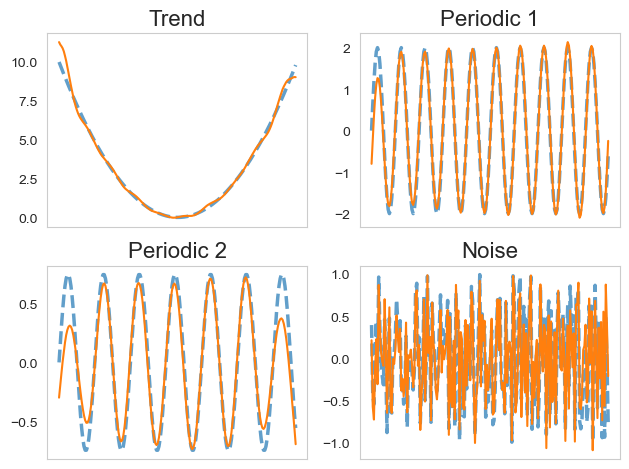

In [18]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0,1,6]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[2,3]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[7:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.grid(False)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", trend, F_trend), 
              ("Periodic 1", periodic1, F_periodic1),
              ("Periodic 2", periodic2, F_periodic2),
              ("Noise", noise, F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.grid(False)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

In [19]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

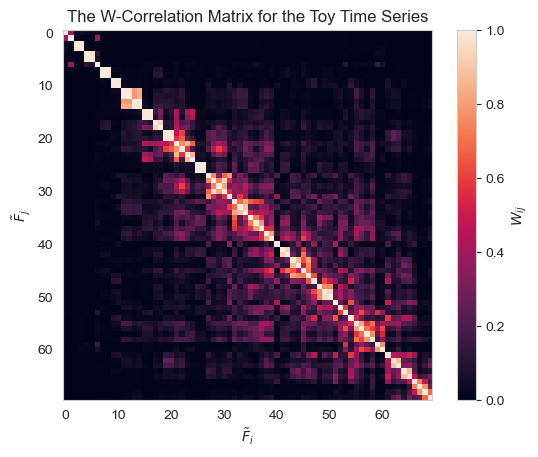

In [21]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.grid(False)
plt.title("The W-Correlation Matrix for the Toy Time Series");

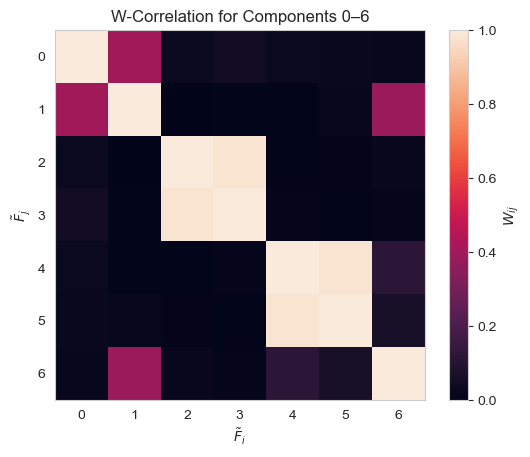

In [22]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.grid(False)
plt.title(r"W-Correlation for Components 0–6");

In [23]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

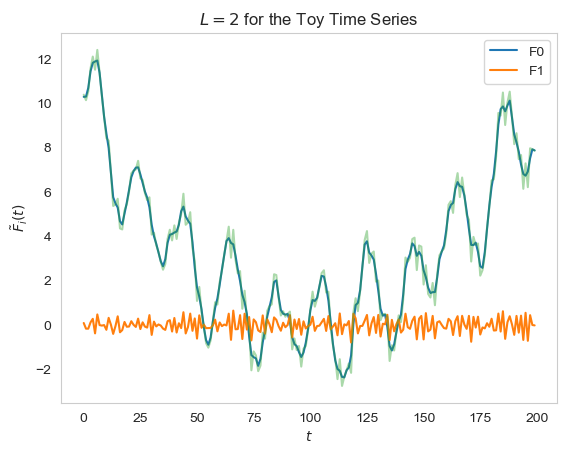

In [24]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.grid(False)
plt.title(r"$L=2$ for the Toy Time Series");

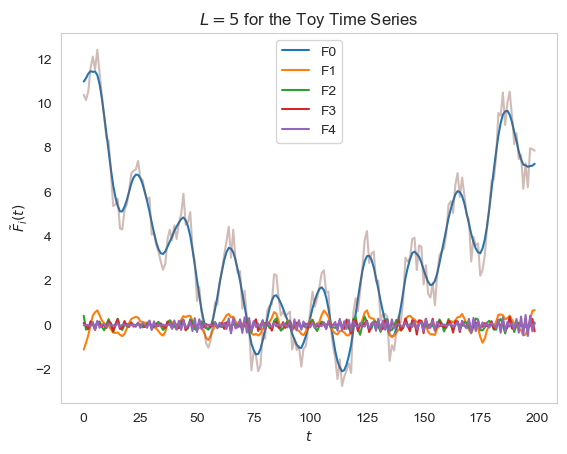

In [26]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.grid(False)
plt.title(r"$L=5$ for the Toy Time Series");
plt.show()

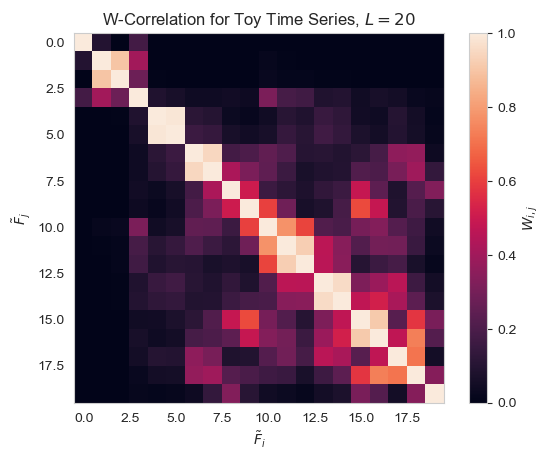

In [28]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.grid(False)
plt.title("W-Correlation for Toy Time Series, $L=20$");

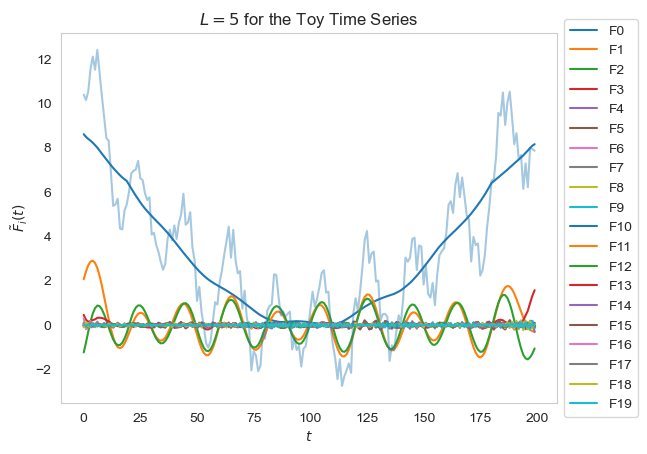

In [30]:
F_ssa_L20.components_to_df().plot()
F_ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.grid(False)
plt.title(r"$L=5$ for the Toy Time Series");
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

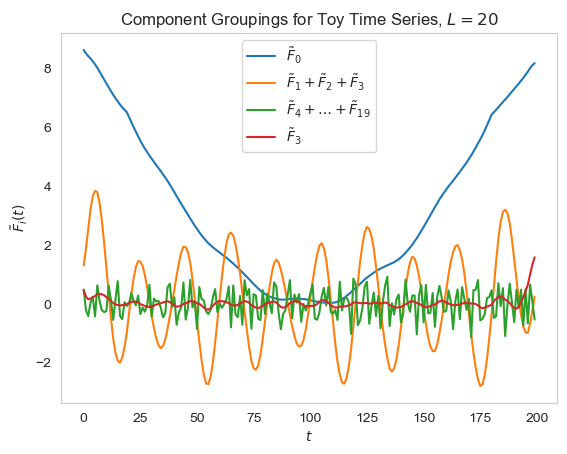

In [32]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.grid(False)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

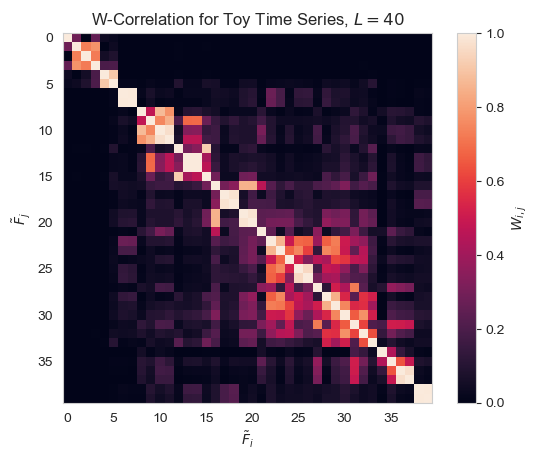

In [34]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.grid(False)
plt.title("W-Correlation for Toy Time Series, $L=40$");

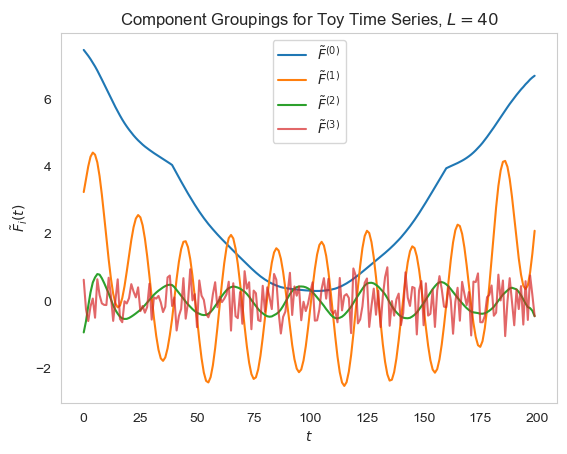

In [35]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3]).plot()
F_ssa_L40.reconstruct([4,5]).plot()
F_ssa_L40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.grid(False)
plt.title("Component Groupings for Toy Time Series, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

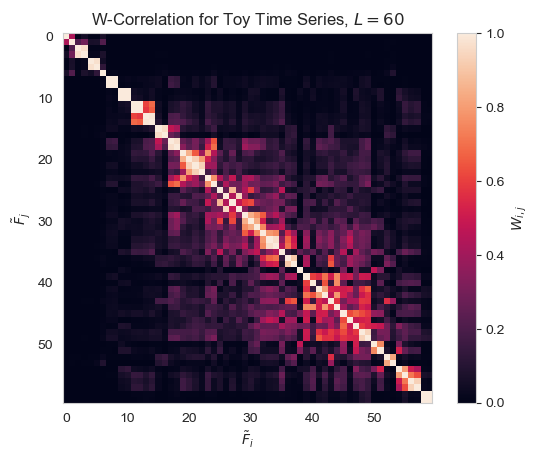

In [36]:
F_ssa_L60 = SSA(F, 60)
F_ssa_L60.plot_wcorr()
plt.grid(False)
plt.title("W-Correlation for Toy Time Series, $L=60$");

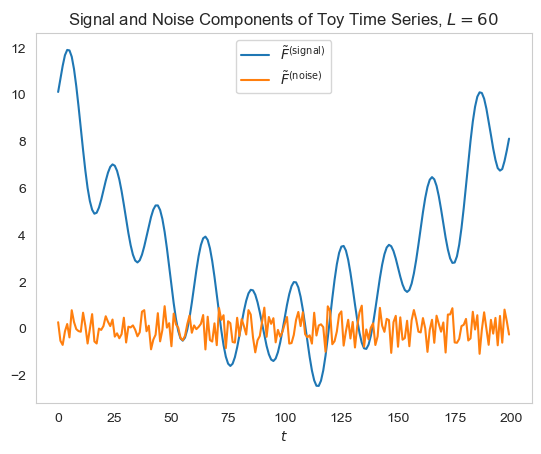

In [39]:
F_ssa_L60.reconstruct(slice(0,7)).plot()
F_ssa_L60.reconstruct(slice(7,60)).plot()
plt.grid(False)
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.xlabel(r"$t$");

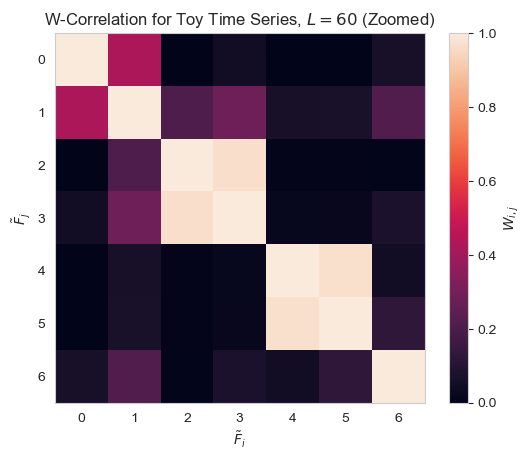

In [41]:
F_ssa_L60.plot_wcorr(max=6)
plt.grid(False)
plt.title("W-Correlation for Toy Time Series, $L=60$ (Zoomed)");

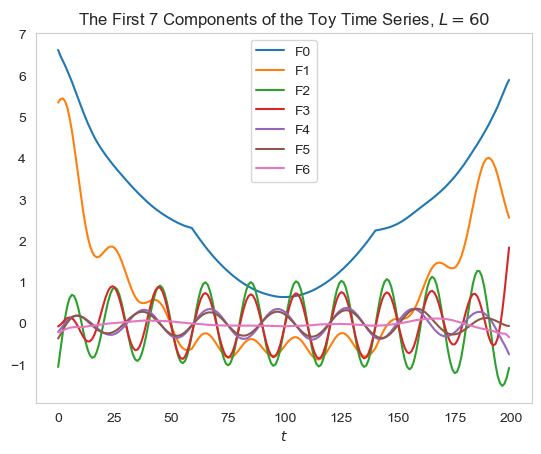

In [42]:
F_ssa_L60.components_to_df(n=7).plot()
plt.grid(False)
plt.title(r"The First 7 Components of the Toy Time Series, $L=60$")
plt.xlabel(r"$t$");

#### Data Analysis

In [44]:
data = pd.read_excel('gdp.xlsx', index_col = 0)
private_consumption = data.iloc[1,:]
capital_formation = data.iloc[5,:]
export = data.iloc[-8,:]
gdp = data.iloc[-1,:]

matrix = pd.concat([gdp, capital_formation, private_consumption, export], axis = 1)
matrix = pd.DataFrame(matrix.values, index = pd.date_range(start = '2000-01-01', end = '2019-03-31', freq = 'Q'),
                      columns = ['GDP','capital_formation','private_consumption','export']).astype('float')
matrix

/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,GDP,capital_formation,private_consumption,export
2000-03-31,190321.8,63385.6,114788.2,56284.9
2000-06-30,205221.2,75929.1,110820.1,62942.2
2000-09-30,209631.1,76956.9,112953.9,64206.4
2000-12-31,215669.6,73464.5,117553.3,67257.6
2001-03-31,198932.5,61724.2,117998.0,60472.2
...,...,...,...,...
2018-03-31,376432.0,125571.5,192356.2,204235.2
2018-06-30,400571.4,136320.9,186147.4,219140.8
2018-09-30,400308.8,126925.8,191461.3,221896.2
2018-12-31,420201.9,138377.4,195452.5,229992.6


In [55]:
matrix_period = matrix.pct_change(periods = 1).dropna()
matrix_period

,GDP,capital_formation,private_consumption,export
2000-06-30,0.078285,0.197892,-0.034569,0.118279
2000-09-30,0.021489,0.013536,0.019255,0.020085
2000-12-31,0.028805,-0.045381,0.040719,0.047522
2001-03-31,-0.077605,-0.159809,0.003783,-0.100887
2001-06-30,0.078412,0.232275,-0.008860,0.015348
...,...,...,...,...
2018-03-31,-0.076392,-0.126848,0.008759,-0.048021
2018-06-30,0.064127,0.085604,-0.032278,0.072983
2018-09-30,-0.000656,-0.068919,0.028547,0.012574
2018-12-31,0.049694,0.090223,0.020846,0.036487


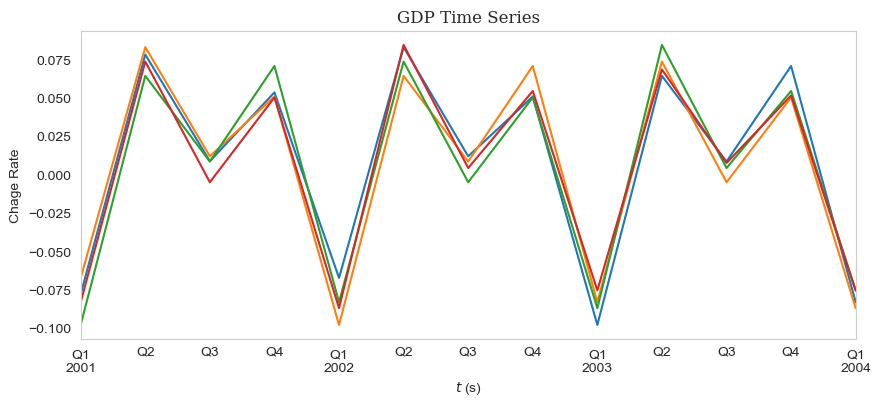

In [68]:
plt.figure(figsize = (10,4))
matrix_period['GDP'][3:16].plot()
matrix_period['GDP'].shift(-4)[3:16].plot()
matrix_period['GDP'].shift(-8)[3:16].plot()
matrix_period['GDP'].shift(-12)[3:16].plot()
plt.xlabel(r"$t$ (s)")
plt.ylabel("Chage Rate")
plt.grid(False)
plt.title("GDP Time Series", fontsize = 12, fontfamily = 'Serif');

In [112]:
start = 0 # seconds, not samples
end = 76 # seconds
window = 20 # samples
accel_ssa = SSA(matrix_period['GDP'][start:end], window)

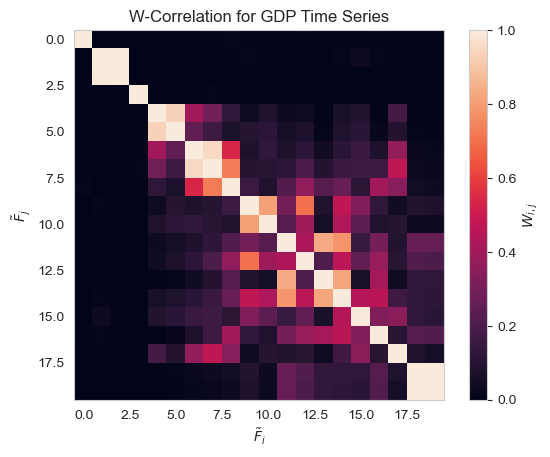

In [113]:
accel_ssa.plot_wcorr()
plt.grid(False)
plt.title("W-Correlation for GDP Time Series");

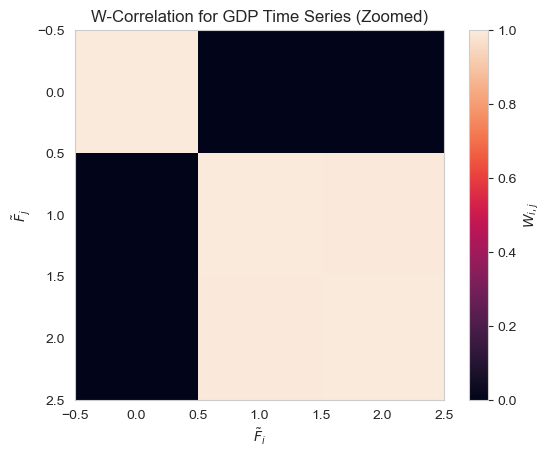

In [114]:
accel_ssa.plot_wcorr(max=2)
plt.grid(False)
plt.title("W-Correlation for GDP Time Series (Zoomed)");

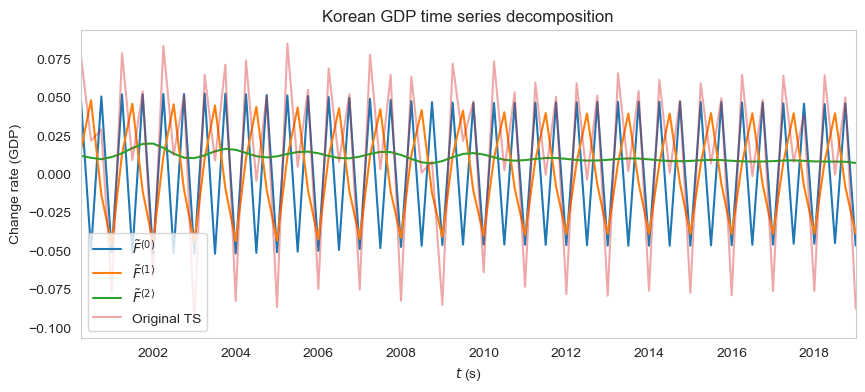

In [118]:
plt.figure(figsize = (10,4))
accel_ssa.reconstruct(0).plot()
accel_ssa.reconstruct([1,2]).plot()
accel_ssa.reconstruct([3,4]).plot()
accel_ssa.orig_TS.plot(alpha=0.4)
plt.title("Korean GDP time series decomposition")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Change rate (GDP)")
plt.grid(False)
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);